In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import librosa
import os
import tqdm
import matplotlib.pyplot as plt
import random
import librosa.display
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset
from sklearn.metrics import classification_report
from sklearn import metrics


In [31]:
def data_read(directory="/content/drive/MyDrive/genres_original"): # change the directory if you like
    data = [] # Store all data (read from music)
    labels = [] # Store corresponding labels
    srs = []

    x = 0

    for dirname, _, filenames in os.walk("/content/drive/MyDrive/genres_original"):
        for filename in filenames:
            # Get name and skip the broken
            if x == 554:  # skip the broken one
                x += 1
                continue

            filename = os.path.join(dirname, filename)

            y, sr = librosa.load(filename)
            #print(filename)
            label = filename.split('/')[5]
            #print(label)

            if label == 'hiphop' or label == 'pop' or label == 'rock' or label == 'blues' or label == 'reggae':
              x += 1
              continue

            # Append them to the final data
            data.append(y)
            labels.append(label)
            srs.append(sr)
            x += 1
            #print(x)  # counting
    #print(len(data))

    return data, labels, srs

In [10]:
data, labels, srs = data_read()

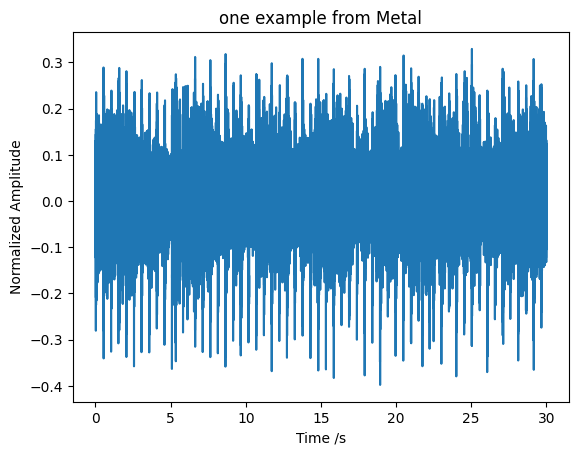

In [11]:
def check():
    fig, axi = plt.subplots(1,1) # initialize
    ind = random.randint(0, len(labels)-1) # randomly choose one index
    times = [sample/srs[ind] for sample in range(len(data[ind]))] # get time axis
    axi.plot(times, data[ind])
    axi.set_ylabel('Normalized Amplitude')
    axi.set_xlabel('Time /s')
    axi.set(title = "one example from " + labels[ind].capitalize())

    plt.show()

check()

In [12]:
def get_mels(data, srs):
    '''
        input: data : array like data structure
               src : sampling rates
               num_mel: how many mel features you want

        return: mels
    '''
    mels = []
    for i in range(len(data)):
        mel = librosa.feature.melspectrogram(y=data[i], sr=srs[i], n_mels= 128, fmax=8000).T
        #print(np.shape(mel))
        mels.append(mel)


    return mels # contains every music's mel

In [13]:
mels = get_mels(data, srs)

In [14]:
def get_mfcc(data, srs, n_mfcc):
    '''Gets mfccs given a array like data structure and its sampling rates
    '''
    mfccs = []
    for i in range(len(data)):
        mfcc = librosa.feature.mfcc(y=data[i], sr=srs[i], n_mfcc=n_mfcc).T
        mfccs.append(mfcc)

    return mfccs

In [15]:
mfccs = get_mfcc(data, srs, n_mfcc=128)
max_length1 = len(max(mfccs, key=len))
def pad_mfcc(mfccs, max_length):
    'pads'
    mfccs_padded = []
    for mfcc in mfccs:
        mfcc_padded = np.pad(mfcc, pad_width=[(0,max_length-mfcc[:,0].shape[0]),(0,0)])
        mfccs_padded.append(mfcc_padded)
    return mfccs_padded


In [16]:
mfccs_padded = pad_mfcc(mfccs, max_length1)
print(np.shape(mfccs_padded[0]))

(1308, 128)


In [17]:
max_length = len(max(mels, key=len)) # get the max length
def pad_mel(mels, max_length):
    'pads'
    mels_padded = []
    for mel in mels:
        mel_padded = np.pad(mel, pad_width=[(0,max_length-mel[:,0].shape[0]),(0,0)])
        mels_padded.append(mel_padded)
    return mels_padded

In [18]:
mels_padded = pad_mel(mels, max_length)
print(np.shape(mels_padded))
mels_padded = np.add(mels_padded, mfccs_padded)
print(np.shape(mels_padded))


(50, 1308, 128)
(50, 1308, 128)


In [19]:
# convert data to numpy array
X = np.asarray(mels_padded)
# Mapping labels
codes = {
    #'blues':0,
    'classical':0,
    'country':1,  #
    'disco':2,
    #'hiphop':4,
    'jazz':3,
    'metal':4,
    #'pop':5,
    #'reggae':4
    #'rock':9  #
}

df_map = pd.DataFrame (labels, columns = ['labels'])
print(df_map)
df_map['labels'] = df_map['labels'].map(codes)
print(df_map)
y = df_map['labels'].to_numpy()
print(y)
print(X)

       labels
0     country
1     country
2     country
3     country
4     country
5     country
6     country
7     country
8     country
9     country
10       jazz
11       jazz
12       jazz
13       jazz
14       jazz
15       jazz
16       jazz
17       jazz
18       jazz
19       jazz
20      metal
21      metal
22      metal
23      metal
24      metal
25      metal
26      metal
27      metal
28      metal
29      metal
30  classical
31  classical
32  classical
33  classical
34  classical
35  classical
36  classical
37  classical
38  classical
39  classical
40      disco
41      disco
42      disco
43      disco
44      disco
45      disco
46      disco
47      disco
48      disco
49      disco
    labels
0        1
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       3
11       3
12       3
13       3
14       3
15       3
16       3
17       3
18       3
19       3
20       4
21       4
22       4
23       4
24       4


In [20]:
# To split train_data, valid_data and test_data
def train_val_test_split(x, y, test_size, val_size, random_state=None, stratify=None):
    x_t, x_test, y_t, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state, stratify=stratify)
    if stratify is not None:
        stratify = y_t
    x_train, x_val, y_train, y_val = train_test_split(x_t, y_t, test_size=val_size, random_state=random_state, stratify=stratify)

    return x_train, y_train, x_val, y_val, x_test, y_test

def to_Dataloader(x_train, y_train, x_val, y_val, x_test, y_test, batch_size, test_batch=1,shuffle=True):

    train_dataset = TensorDataset(torch.Tensor(x_train),torch.Tensor(y_train).type(torch.LongTensor)) # create train_dataset
    val_dataset = TensorDataset(torch.Tensor(x_val),torch.Tensor(y_val).type(torch.LongTensor)) # create val_dataset
    test_dataset = TensorDataset(torch.Tensor(x_test),torch.Tensor(y_test).type(torch.LongTensor)) # create test_dataset

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle) # create your train_dataloader
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle) # create your val_dataloader
    test_dataloader = DataLoader(test_dataset, batch_size=test_batch, shuffle=shuffle) # create your test_dataloader

    return train_dataloader, val_dataloader, test_dataloader

In [21]:
x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(X, y, test_size=0.15, val_size=0.15, random_state=42, stratify=y)

train_dataloader, val_dataloader, test_dataloader = to_Dataloader(x_train, y_train, x_val, y_val, x_test, y_test, batch_size=64, test_batch=1,shuffle=True)

print('finished')

finished


In [22]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [23]:
# Then we wanna define a resnet
class MelSpecClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block
        self.b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=1),
                   nn.PReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                   nn.BatchNorm2d(64)
                   )



        conv_layers += [self.b1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(64, 256, kernel_size=5, stride=2, padding=1)
        self.relu2 = nn.PReLU()
        self.bn2 = nn.BatchNorm2d(256)
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.relu3 = nn.PReLU()
        self.bn3 = nn.BatchNorm2d(512)
        conv_layers += [self.conv3, self.relu3, self.bn3,]


        # 5th Convolution Block
        self.conv4 = nn.Conv2d(512, 256, kernel_size=3, stride=2, padding=1)
        self.relu4 = nn.PReLU()
        self.bn4 = nn.BatchNorm2d(256)
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # 6th Convolution Block
        self.conv5 = nn.Conv2d(256, 128, kernel_size=3, stride=2, padding=1)
        self.relu5 = nn.PReLU()
        self.bn5 = nn.BatchNorm2d(128)
        conv_layers += [self.conv5, self.relu5, self.bn5]


        # Dropout Layer
        self.drp = nn.Dropout2d(p = 0.4)

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc = nn.Linear(in_features=128, out_features=64)

        # Wrap the Convolutional Blocks
        self.fitter = nn.Sequential(*conv_layers, self.drp, self.ap, nn.Flatten(), self.fc, nn.Linear(in_features=64, out_features=5))

        self.initialize_weights()


    def forward(self, x):

        x = x.transpose(1,2)
        x.unsqueeze_(1)
        out = self.fitter(x)
        return out




    def initialize_weights(self) :
        for m in self.modules() :
            if isinstance(m, nn.Conv2d) :
                nn.init.kaiming_normal_(m.weight, a = 0.1)

                if m.bias is not None :
                    nn.init.constant_(m.bias, 0)


In [24]:
# check the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [25]:
def training_loop(model, train_dataloader, optimizer, device=device):

    model.train() # Sets model to train mode
    batch_losses = []

    for x_batch, y_batch in train_dataloader:
        # Move batches to device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Clear gradients
        optimizer.zero_grad()

        yhat = model(x_batch)  #predictions on x

        # Forward pass
        loss = loss_function(yhat, y_batch)

        # Backward and optimize
        loss.backward()

        # Update parameters
        optimizer.step()

        batch_losses.append(loss.data.item())

    train_loss = np.mean(batch_losses)

    return train_loss  # Return train_loss and anything else you need

def validation_loop(model, val_dataloader, device=device):

    model.eval() # Sets model to val mode

    batch_losses = []

    for x_batch, y_batch in val_dataloader:

        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        yhat = model(x_batch)  #predictions on x

        loss = loss_function(yhat, y_batch)

        batch_losses.append(loss.data.item())

    val_loss = np.mean(batch_losses)

    return val_loss

def train(model, train_dataloader, val_dataloader, optimizer, epochs, device="cuda", patience = None, temp=100):

    train_losses = []
    val_losses = []

    print(f"Initiating training.")

    # Check if early stop is enabled:
    if patience is not None:
        # Initialize EarlyStopping
        early_stopping = EarlyStopping(patience=patience, verbose=False, path='checkpoint.pt')

    for epoch in range(epochs):
        # Training loop

        train_loss = training_loop(model, train_dataloader, optimizer, device)
        train_losses.append(train_loss)

        # Validation loop
        with torch.no_grad():

            val_loss = validation_loop(model, val_dataloader, device)
            val_losses.append(val_loss)

        if patience != -1:
            early_stopping(val_loss, model)

            if early_stopping.early_stop:
                print("Early stop. Going back to the last checkpoint.")
                break

        if epoch % temp == 0:
            print(f"[{epoch}/{epochs}] Training loss: {train_loss:.4f}\t Validation loss: {val_loss:.4f}.")

    if patience != None and early_stopping.early_stop == True:
        print('Loading model from checkpoint...')
        model.load_state_dict(torch.load('checkpoint.pt'))
        print('Checkpoint loaded.')

    print("training finished.")

    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10, 8))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')

    # find position of lowest validation loss
    minposs = val_losses.index(min(val_losses)) + 1
    plt.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, max(val_losses + train_losses))  # consistent scale
    plt.xlim(0, len(train_losses) + 1)  # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.title('Validation and Training Loss of CNN')
    plt.show()

    return model


def predict(model, test_loader, n_features, loss_function, device=device):
    # Make predictions using model
    preds = []
    true_values = []
    loss = 0
    model.eval()  # prep model for evaluation

    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            # move to device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Make predictions
            pred = model(x_batch)

            preds.append(np.argmax(pred.cpu().numpy(), axis=1)[0])
            true_values.append(y_batch.cpu().numpy()[0])
            loss += loss_function(pred, y_batch)

        #Calculate Accuracy
        accuracy = sum(np.array(preds) == np.array(true_values))/len(true_values)

    return preds, true_values, accuracy

In [26]:
model = MelSpecClassifier()
model.to(device)

MelSpecClassifier(
  (b1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Conv2d(64, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (relu2): PReLU(num_parameters=1)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu3): PReLU(num_parameters=1)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu4): PReLU(num_parameters=1)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 128, kernel_size=(3, 3), stride=(2, 2), pad

In [27]:
learning_rate = 0.00011
weight_decay = 1e-4


loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

Initiating training.
[0/1000] Training loss: 1.6643	 Validation loss: 1.4106.
[5/1000] Training loss: 0.8452	 Validation loss: 1.0443.
[10/1000] Training loss: 0.6195	 Validation loss: 0.7842.
[15/1000] Training loss: 0.4425	 Validation loss: 0.6180.
[20/1000] Training loss: 0.3523	 Validation loss: 0.5066.
[25/1000] Training loss: 0.2685	 Validation loss: 0.4464.
[30/1000] Training loss: 0.1846	 Validation loss: 0.4177.
[35/1000] Training loss: 0.1419	 Validation loss: 0.3942.
[40/1000] Training loss: 0.1145	 Validation loss: 0.3667.
[45/1000] Training loss: 0.0950	 Validation loss: 0.3544.
[50/1000] Training loss: 0.0707	 Validation loss: 0.3407.
[55/1000] Training loss: 0.0730	 Validation loss: 0.3168.
[60/1000] Training loss: 0.0697	 Validation loss: 0.3016.
[65/1000] Training loss: 0.0503	 Validation loss: 0.2932.
[70/1000] Training loss: 0.0504	 Validation loss: 0.2780.
[75/1000] Training loss: 0.0396	 Validation loss: 0.2594.
[80/1000] Training loss: 0.0399	 Validation loss: 0.2

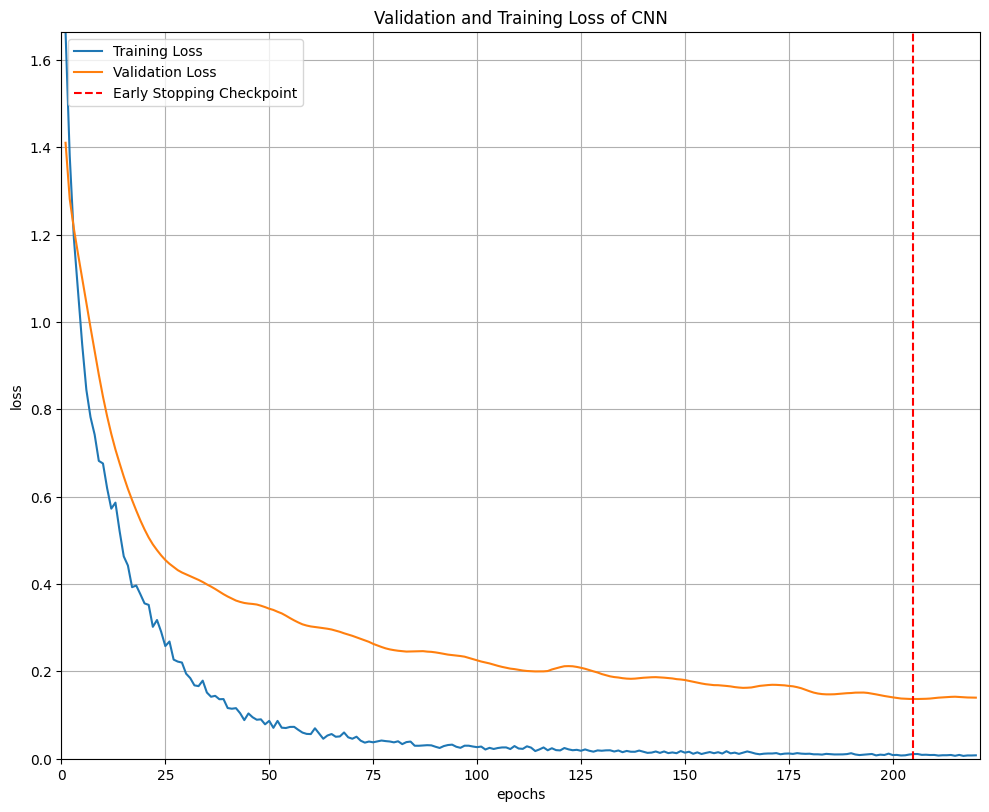

In [28]:
model = train(model, train_dataloader, val_dataloader, optimizer, epochs=1000, device="cuda", patience = 15, temp=5)

In [29]:
preds, true_values, accuracy = predict(model, test_dataloader, n_features=128, loss_function=loss_function, device=device)
print(classification_report(true_values, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         1

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



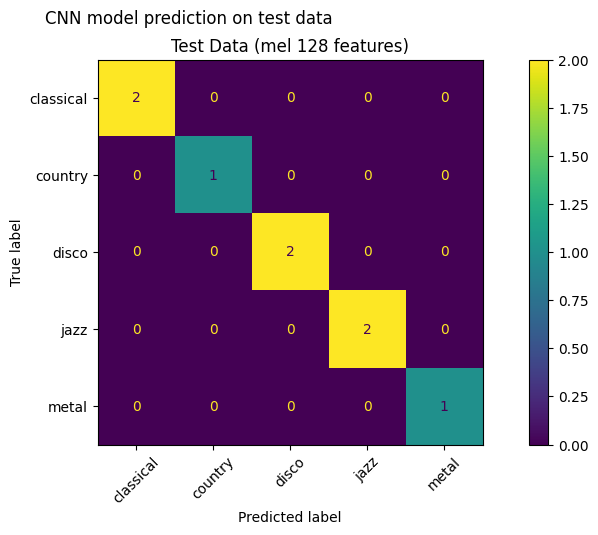

In [30]:
classlist = list(codes.keys())

# Plotting confusion matrices for small and big data
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))  # Set up the figure


y_ = [true_values]
preds_lst = [preds]
titles = ['Test Data (mel 128 features)']
for i in range(1):
    actual = y_[i]
    predicted =preds_lst[i]  # get the prediction for each model (each loop)

    confusion_matrix = metrics.confusion_matrix(np.array(actual), np.array(predicted))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    cm_display.plot(ax=ax)
    ax.set_xticklabels(classlist, rotation=45)
    ax.set_yticklabels(classlist)
    ax.set_title(titles[i])

fig.suptitle('CNN model prediction on test data')
plt.show()